In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ratthachat/writing-prompts")

print("Path to dataset files:", path)

Path to dataset files: /home/kelvin/.cache/kagglehub/datasets/ratthachat/writing-prompts/versions/1
Path to dataset files: /home/kelvin/.cache/kagglehub/datasets/ratthachat/writing-prompts/versions/1


In [2]:
import pandas as pd
import os

# The dataset path variable 'path' is already set from previous cell
# Let's list files in the dataset directory
fname = "writingPrompts"
dataset_dir = os.path.join(path, fname)
print('Files in dataset directory:', os.listdir(dataset_dir))


Files in dataset directory: ['test.wp_source', 'valid.wp_target', 'valid.wp_source', 'test.wp_target', 'train.wp_source', 'train.wp_target', 'README']


In [3]:
fname = "train.wp_source"
train_source_path = os.path.join(dataset_dir, fname)
fname = "train.wp_target"
train_target_path = os.path.join(dataset_dir, fname)
# Load data into pandas DataFrame
train_source_data = pd.read_csv(train_source_path, delimiter='\t', header=None, names=['Source'])
train_target_data = pd.read_csv(train_target_path, delimiter='\t', header=None, names=['Target'])

# Display the first few rows of the loaded data
print("Training Source Data:")
print(train_source_data.head())

print("\nTraining Target Data:")
print(train_target_data.head())

Training Source Data:
                                              Source
0  [ WP ] You 've finally managed to discover the...
1  [ WP ] The moon is actually a giant egg , and ...
2  [ WP ] You find a rip in time walking through ...
3  [ WP ] For years in your youth the same imagin...
4  [ WP ] You glance at your watch 10:34 am , rou...

Training Target Data:
                                              Target
0  So many times have I walked on ruins , the rem...
1  -Week 18 aboard the Depth Reaver , Circa 2023-...
2  I was feckin ' sloshed , mate . First time I e...
3  “ No , no no no ... ” She backed up and turned...
4  There 's a magical moment between wakefulness ...


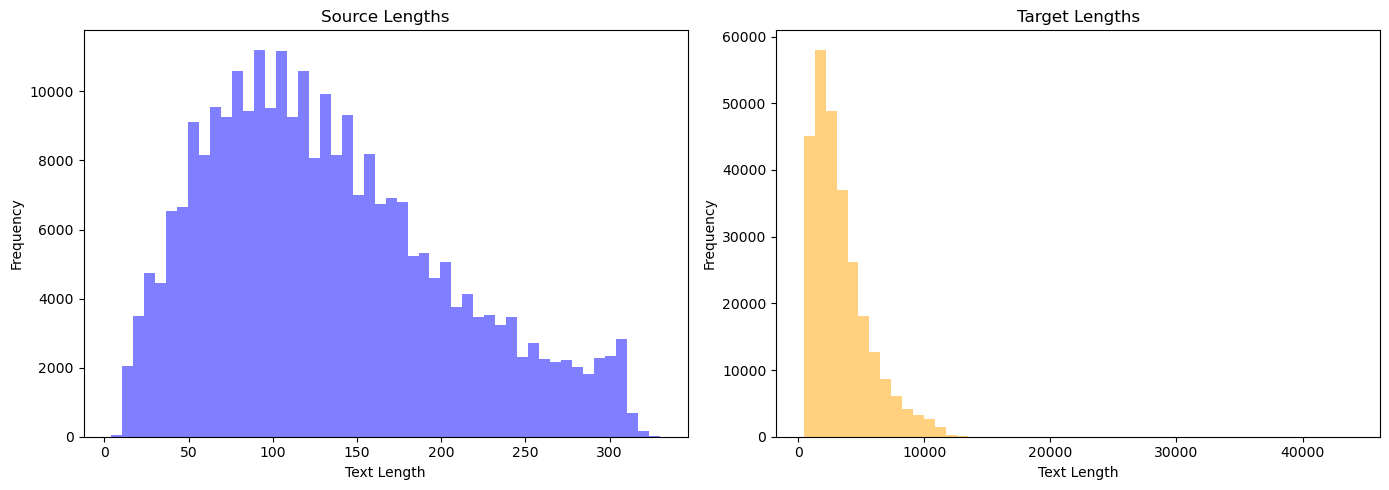

In [5]:
import matplotlib.pyplot as plt

# Assuming train_source_data and train_target_data are already loaded
source_lengths = train_source_data['Source'].apply(len)
target_lengths = train_target_data['Target'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(source_lengths, bins=50, alpha=0.5, color='blue')
axs[0].set_title('Source Lengths')
axs[0].set_xlabel('Text Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(target_lengths, bins=50, alpha=0.5, color='orange')
axs[1].set_title('Target Lengths')
axs[1].set_xlabel('Text Length')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [6]:
print("Source Length Statistics:")
print(source_lengths.describe())

print("\nTarget Length Statistics:")
print(target_lengths.describe())

Source Length Statistics:
count    272600.000000
mean        133.173485
std          70.954249
min           4.000000
25%          78.000000
50%         122.000000
75%         178.000000
max         330.000000
Name: Source, dtype: float64

Target Length Statistics:
count    272600.000000
mean       3325.489578
std        2244.630473
min         430.000000
25%        1639.000000
50%        2742.000000
75%        4392.000000
max       43963.000000
Name: Target, dtype: float64


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    return text

train_source_data['Cleaned_Source'] = train_source_data['Source'].apply(clean_text)
train_target_data['Cleaned_Target'] = train_target_data['Target'].apply(clean_text)

In [ ]:
# from nltk.tokenize import word_tokenize

# train_source_data['Tokenized_Source'] = train_source_data['Cleaned_Source'].apply(word_tokenize)
# train_target_data['Tokenized_Target'] = train_target_data['Cleaned_Target'].apply(word_tokenize)

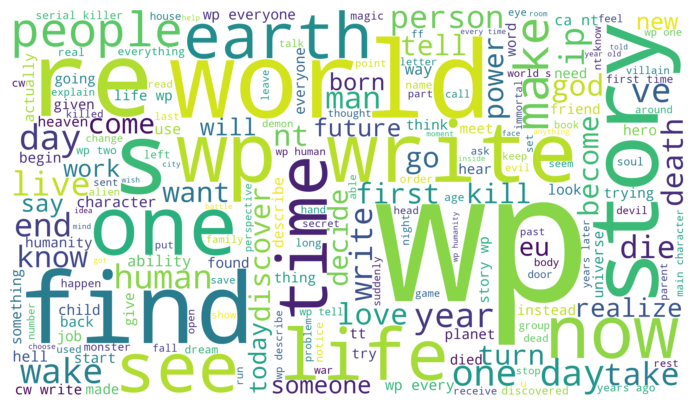

In [ ]:
from wordcloud import WordCloud

# Assuming nltk and wordcloud are installed
all_text = ' '.join(train_source_data['Cleaned_Source'])
wordcloud = WordCloud(width=2800, height=1600, max_words=200, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Load your dataset
# Assuming train_source_data and train_target_data are already loaded

# Define a custom dataset
class WritingPromptsDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)






In [7]:
# Tokenize and encode the data
# Reduce the dataset size for faster experimentation
sample_size = 5000
train_source_sample = train_source_data['Cleaned_Source'].sample(n=sample_size, random_state=42).tolist()
train_target_sample = train_target_data['Cleaned_Target'].sample(n=sample_size, random_state=42).tolist()

train_source_encodings = tokenizer(
    train_source_sample,
    return_tensors='pt',
    truncation=True,
    padding=True,
    max_length=128
)
train_target_encodings = tokenizer(
    train_target_sample,
    return_tensors='pt',
    truncation=True,
    padding=True,
    max_length=128
)

In [23]:
# Create datasets and dataloaders
train_dataset = WritingPromptsDataset(train_source_encodings)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Fine-tune the model (example, you may need to adjust parameters)
accumulation_steps = 4  # Accumulate gradients over 4 batches before updating
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)




In [10]:
import pickle

# Save train_dataset
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

# Save train_dataloader (note: DataLoader objects are not always serializable, but you can save its state_dict or parameters)
torch.save(train_dataloader, 'train_dataloader.pt')

In [17]:
import torch
print(torch.cuda.is_available())   # should be True
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3050 Laptop GPU


In [20]:
batch = next(iter(train_dataloader))
batch = {k: v.to(device) for k, v in batch.items()}
with torch.no_grad():
    outputs = model(**batch, labels=batch["input_ids"])
    print("Model ran without error.")


/tmp/ipykernel_16672/2367361022.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(3):
    for i, batch in enumerate(train_dataloader):
        try:
            # Ensure all tensors go to the same device
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch, labels=batch["input_ids"])
            loss = outputs.loss
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            break


Error in batch 0: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Error in batch 0: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Error in batch 0: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



/tmp/ipykernel_16672/2367361022.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [16]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # For clearer error messages

model.train()

for epoch in range(3):
    for i, batch in enumerate(train_dataloader):
        try:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch["input_ids"]
            outputs = model(**batch, labels=labels)
            loss = outputs.loss
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        except RuntimeError as e:
            print(f"Error in batch {i}: {e}")
            break


Error in batch 0: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Error in batch 0: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Error in batch 0: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



/tmp/ipykernel_16672/2367361022.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
# Save the fine-tuned model
model.save_pretrained('./fine_tuned_TinyLlama_model')
tokenizer.save_pretrained('./fine_tuned_TinyLlama_model')

# Load the fine-tuned model and generate stories
fine_tuned_model = AutoModelForCausalLM.from_pretrained('./fine_tuned_TinyLlama_model')
fine_tuned_tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_TinyLlama_model')

In [ ]:
# Generate stories
def generate_story(prompt, model, tokenizer, max_length=2000):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    output = model.generate(input_ids, max_length=max_length, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text



In [ ]:
# Example usage
prompt = "In a world where dragons exist,"
generated_story = generate_story(prompt, fine_tuned_model, fine_tuned_tokenizer)
print(generated_story)